# PCA Visualization

**Author**: Julien de la Bruère-Terreault drgfreeman@tuta.io  
**Source**: https://github.com/DrGFreeman/rps-cv-data-science  
**License**: MIT

## Introduction
This notebook presents a visualisation of the Principal Component Analysis (PCA) method used as dimensionality reduction in my **Rock-Paper-Scissors game using computer vision and machine learning on the Raspberry Pi** project ([DrGFreeman/rps-cv](https://github.com/DrGFreeman/rps-cv)).

The objective of this notebook is mainly to develop an intuition of the meaning of PCA applied to images rather than to present a mathematically rigorous definition of PCA. For the latter, refer to [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis) which does a much better job at this than I could ever do.

### Import packages
In addition to the common Numpy, and Scikit-Learn packages, this notebook also requires the [rpscv](https://github.com/DrGFreeman/rps-cv) package for preprocessing of the images. The instructions to install these packages are given in the README of the [GitHub repository](https://github.com/DrGFreeman/rps-cv-data-science).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interactive
from ipywidgets import Layout
import ipywidgets as widgets

from sklearn.decomposition import PCA

from rpscv import imgproc

## Dataset exploration
We use the `generateGrayFeatures` function of the `rpscv.imgproc` module to load the image data `X` and labels `y`. This functions pre-processes the images to remove the green background and returns an array of grayscale images along with a vector of image labels.

In [2]:
X, y = imgproc.generateGrayFeatures()

Completed processing 2188 images


Let's check the shapes of the features `X` and labels `y` arrays.

In [3]:
X.shape, y.shape

((2188, 60000), (2188,))

There are 2188 images in the dataset. The `X` array stores the images, each represented as a vector of 60,000 pixel intensity values. These correspond to the 200 x 300 pixels of the original images in a flattened form.

We can pick any image from the `X` array, reshape it to its original dimensions and display it using the pyplot `imshow` function:

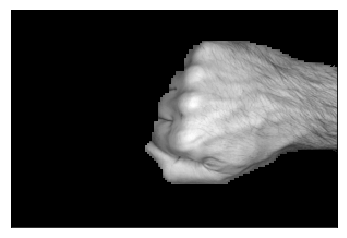

In [4]:
img = X[100].reshape((200, 300))
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

The `y` array stores the lables corresponding to each image encoded as integers.

In [5]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([726, 712, 750]))

The text labels corresponding to the integer labels are stored in the `improc.utils.gesturesTxt` dictionary.

In [6]:
for i in np.unique(y):
    print(i, imgproc.utils.gestureTxt[i])

0 rock
1 paper
2 scissors


## Principal Component Analysis
To perform Principal Component Analysis, we use the `PCA` transformer from the Scikit-Learn `decomposition` module. For this demonstration, we choose to extract the 40 first principal components. When using PCA as a dimensionality reduction step in a machine learning pipeline, the number of principal components to extract is a parameter that can be tuned along with other model hyperparameters.

With the PCA transformer defined, we fit it to the array of image feature vectors `X`.

In [7]:
pca = PCA(n_components=40)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The principal components are orthogonal vectors, in the original feature space, where the first component represents the axis of maximum variance in the data, the second components represents the second axis of maximum variance, and so on, in order of decreasing value of explained variance.

The explained variance ratio (*explained_variance* / *total_variance*) of each component can be accessed from the `explained_variance_ratio_` attribute of the PCA object.

Let's plot the explained variance ratio of each principal component.

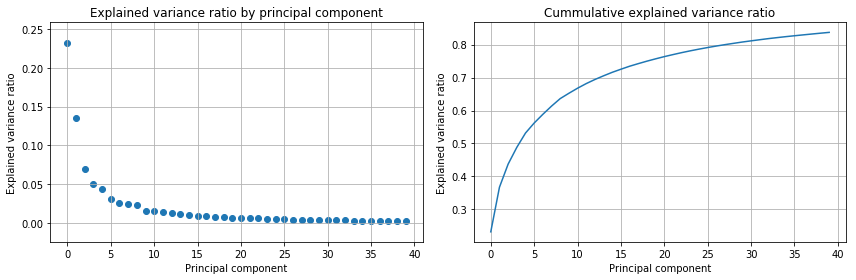

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio by principal component')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Cummulative explained variance ratio')
plt.grid()
plt.tight_layout()
plt.show()

We can see that the first 40 principal components explain more than 80% of the total variance and the first 5 components explain more than 50% of the total variance.  As the number of components increases, the variance explained by each new component reduces.

### Principal component vectors

The calculated principal components are available as the `components_` attribute of the fitted PCA object.

Let's look at the shape of the principal components array.

In [9]:
pca.components_.shape

(40, 60000)

As we specified, the principal components array contains 40 components, each represented by a vector of dimension 60,000.

**The principal component vectors always have the same shape as the input features vector**.

This means that we can visualize the principal components the same way as we visualize the input images.
Let's look at the first principal component vector reshaped to dimensions 200 x 300.

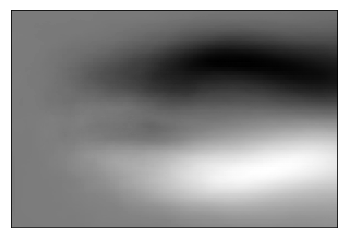

In [10]:
plt.imshow(pca.components_[0].reshape((200, 300)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Along with the principal component vectors, the PCA transformer also computes the mean of all the input images. This mean is stored as the `mean_` attribute of the PCA object.

In [11]:
pca.mean_.shape

(60000,)

As expected, the mean has the same shape as the input features vector and the principal components vectors. We can therefore visualize the mean after reshaping it to the dimensions of the original images.

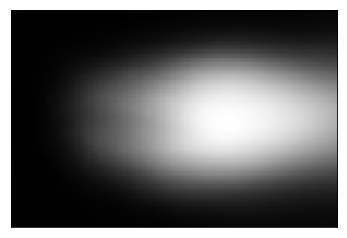

In [12]:
plt.imshow(pca.mean_.reshape((200, 300)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Lets now plot all the 40 principal component vectors as images. We include the explained variance ratio of each principal component in the title as reference.

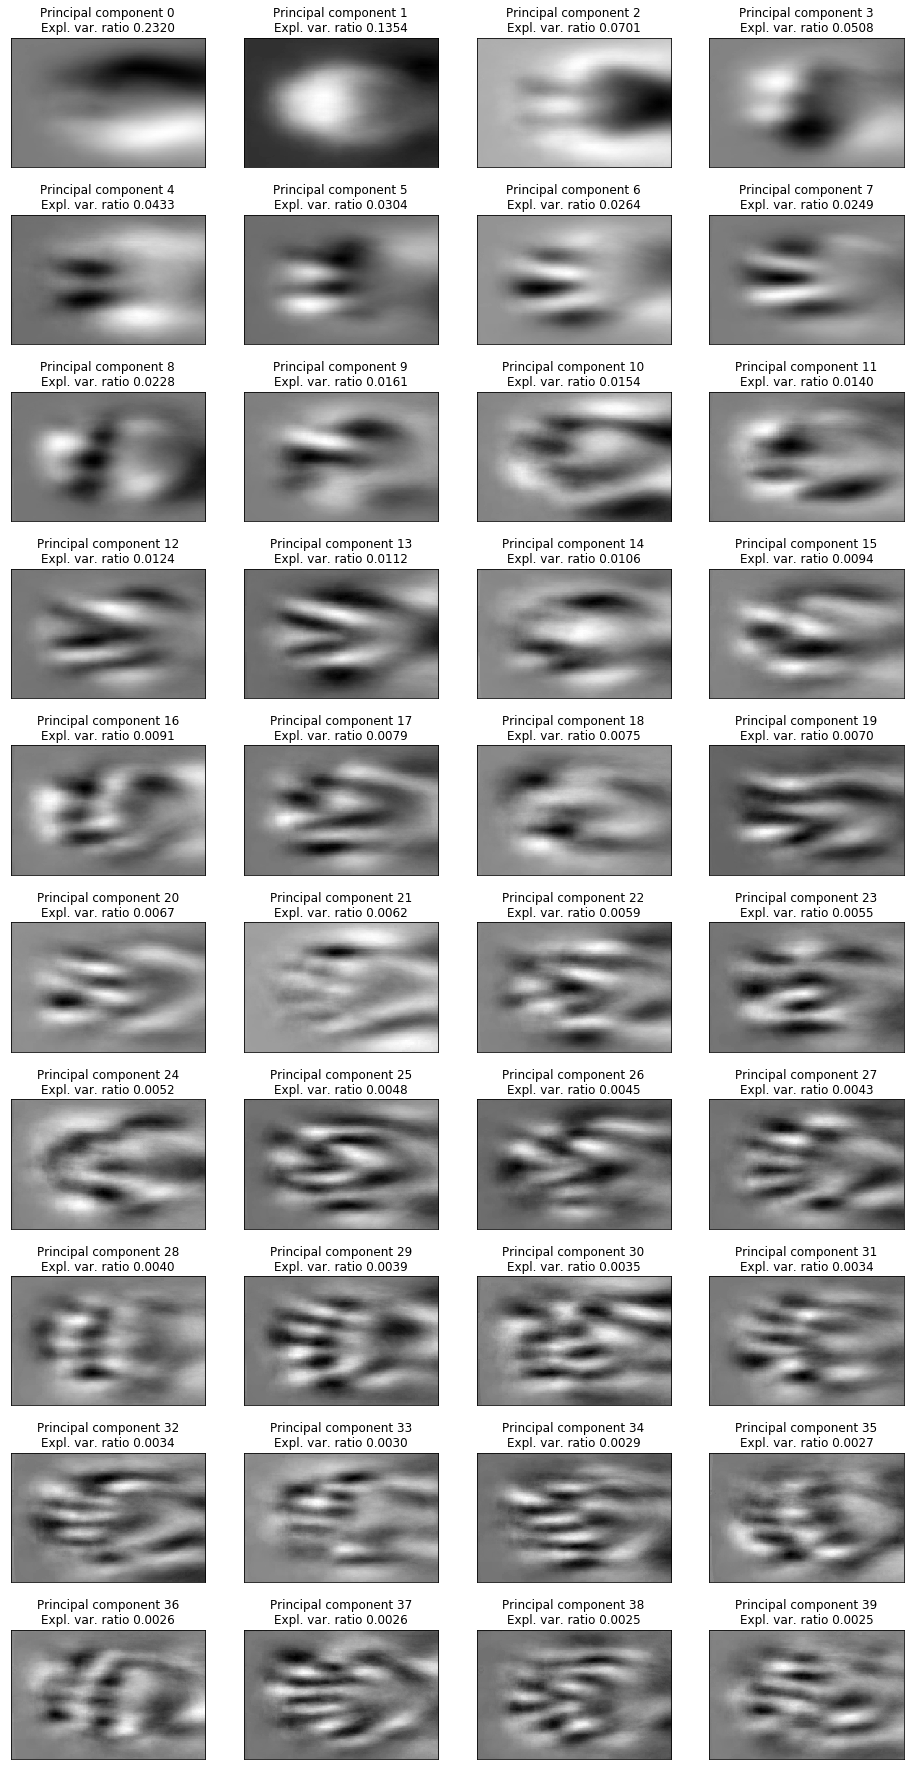

In [13]:
pc_imgs = pca.components_.reshape((len(pca.components_), 200, 300))

nb_col = 4
nb_row = pc_imgs.shape[0] // nb_col
plt.figure(figsize=(4 * nb_col, 3.2 * nb_row))
for i in range(nb_col * nb_row):
    plt.subplot(nb_row, nb_col, i+1)
    plt.imshow(pc_imgs[i], cmap='gray')
    plt.title("Principal component {:d}\nExpl. var. ratio {:.4f}".format(i, pca.explained_variance_ratio_[i]))
    plt.xticks(())
    plt.yticks(())
plt.show()

The plots of the principal components vectors show that the first principal components encode relatively simple shapes. As the principal component number increases, the shapes represented by each principal component become more and more complex.

### Representation of images by their principal components

When using PCA as a means of dimensionality reduction, we want to encode each image in a vector of lower dimension than the original. This vector corresponds to factors by which we can multiply each of the principal component vectors to represent the original image. Let's go through this step by step.

First, we use the PCA object `transform` method to transform our original image feature vectors into their principal component representation.

In [14]:
X_pca = pca.transform(X)

X_pca.shape

(2188, 40)

Our transformed features array `X_pca` now represent each image by a vector of dimension 40. We have therefore reduced our feature space from 60,000 dimensions to 40 dimensions, a reduction factor of 1500X !

We can pick any image from the transformed feature array and look at its content.

In [15]:
X_pca[123]

array([-16.32979   , -21.632301  ,  -7.0697923 , -13.034341  ,
         6.6281495 ,   4.3793535 ,  -1.4592674 ,   1.977295  ,
        10.991823  ,  -3.8272321 ,  -5.337607  ,   3.5030322 ,
        -3.1290221 ,   4.3966184 ,  -0.94440806,  -0.2714582 ,
        -0.04108937,   1.1239651 ,  -0.4913989 ,   1.4429313 ,
        -1.0721407 ,  -3.0769176 ,   1.8549172 ,   0.8818205 ,
         4.096809  ,  -0.30815163,   1.3656435 ,   1.767221  ,
         3.1396797 ,   1.3680649 ,  -0.18175   ,  -0.6378259 ,
         1.974003  ,   3.6510384 ,  -1.3593367 ,  -0.53318554,
        -0.8868299 ,  -0.14854449,  -2.6383703 ,   3.489646  ],
      dtype=float32)

We can use the 40 coefficients from this vector to multiply the 40 principal component vectors. This corresponds to the dot product of the transformed feature vector by the array of principal components vectors. We can then add the PCA mean vector and obtain an image vector reconstructed from the principal components.

In [16]:
img_from_pcs = np.dot(X_pca[123], pca.components_) + pca.mean_

img_from_pcs.shape

(60000,)

We reshape this image vector to 200 x 300 pixels and display it alongside the original image.

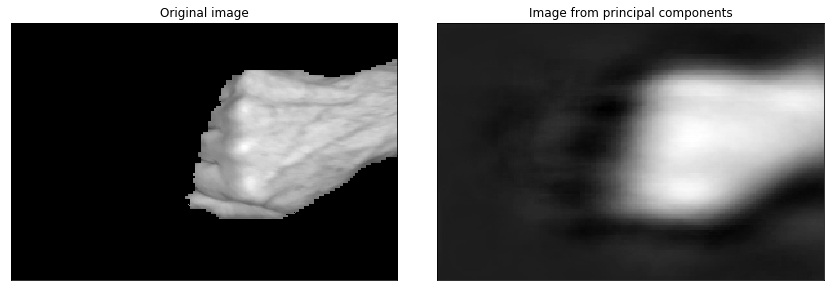

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(X[123].reshape((200, 300)), cmap='gray')
plt.title('Original image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(img_from_pcs.reshape((200, 300)), cmap='gray')
plt.title('Image from principal components')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

The `inverse_transform` method of the PCA class allows to perform this transformation from the principal component space to the original image feature space on the entire array of transformed images with ease.

In [18]:
X_from_pcs = pca.inverse_transform(X_pca)

X_from_pcs.shape

(2188, 60000)

Lets now pick three images, one image of each class, and display the original image, the transformed feature vector and the image reconstructed from the principal component vectors.

In [19]:
rock = X[100]
paper = X[800]
scissors = X[1502]

We define a function to apply the same plot setup to the three images.

In [20]:
def show_img_pcs(img):
    plt.figure(figsize=(16, 4))
    
    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(img.reshape(200, 300), cmap='gray');
    plt.title('Original image')
    plt.xticks(())
    plt.yticks(())
    
    #Display principal components magnitude
    plt.subplot(1, 3, 2)
    img_pc = pca.transform([img])
    plt.bar(range(1, img_pc.shape[1] + 1), img_pc[0,:])
    plt.title('Image principal components magnitude')
    plt.xlabel('Principal component')
    plt.ylabel('Magnitude')
    
    # Display reconstituted image
    plt.subplot(1, 3, 3)
    plt.imshow(pca.inverse_transform(img_pc).reshape(200, 300), cmap=plt.cm.gray)
    plt.title('Image reconstructed from principal components')
    plt.xticks(())
    plt.yticks(())
    
    plt.tight_layout()
    plt.show()

And plot the three images.

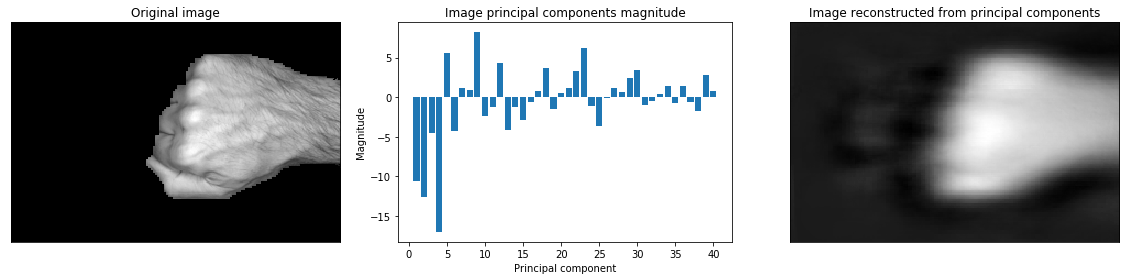

In [21]:
show_img_pcs(rock)

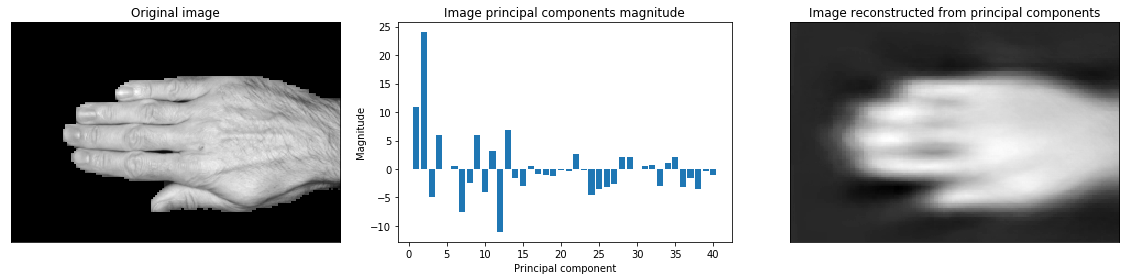

In [22]:
show_img_pcs(paper)

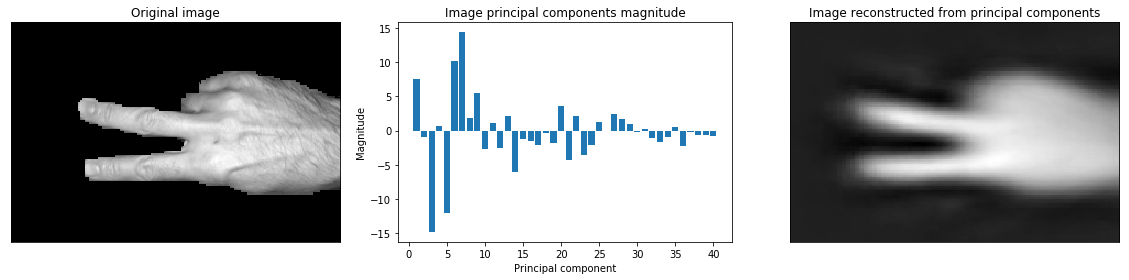

In [23]:
show_img_pcs(scissors)

We create a function to show the contribution of each of the principal component vectors in the progressive reconstruction of an image based on its features in the principal component space.

In [24]:
def progressive_plot(index, n_components):
    i = n_components - 1
    img = X[index]
    img_pc = X_pca[index]
    plt.figure(figsize=(12, 8))
    # Plot the original image
    plt.subplot(2, 2, 1)
    plt.imshow(img.reshape((200, 300)), cmap='gray')
    plt.title('Original image')
    plt.xticks([])
    plt.yticks([])
    # Plot the reconstructed image
    plt.subplot(2, 2, 2)
    if i == -1:
        plt.imshow(pca.mean_.reshape((200, 300)), cmap='gray')
        plt.title('Mean')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow((np.dot(img_pc[:i+1], pca.components_[:i+1])
                    + pca.mean_).reshape((200, 300)), cmap='gray')
        plt.title('Principal components 0 to {} + mean'.format(i))
        plt.xticks([])
        plt.yticks([])
    # Plot the bargraph
    plt.subplot(2, 2, 3)
    bars = plt.bar(range(pca.n_components_), img_pc, color='lightgray')
    if i >= 0:
        for j in range(n_components):
            bars[j].set_color('#6495ED')
        bars[i].set_color('r')
    plt.title('Image principal components magnitude')
    plt.xlabel('Principal component')
    plt.ylabel('Magnitude')
    # Plot the scaled principal component vector being added
    plt.subplot(2, 2, 4)
    if i == -1:
        plt.imshow(pca.mean_.reshape((200, 300)), cmap='gray')
        plt.title('Mean')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow((img_pc[i] * pca.components_[i]) .reshape((200, 300)), cmap='gray')
        plt.title('Principal component vector {} * {:.3g}'.format(i, img_pc[i]))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

The *index* slider allow selection of the index of the image to dislay.
The *n_components* slider selects the number of principal components used for the reconstruction. Increasing this slider from 0 (only the mean) to the maximum number of principal components shows the contribution of each principal component in the reconstructed image.

The top left image shows the original image. The top right corner shows the image reconstructed with the selected number of principal components. The bottom left bargraph shows the magnitude of each principal component in the selected image in light gray. In red is the current principal component magnitude which is also represented in the bottom right image. In blue are the magnitudes of the lower principal components which, along with the current principal component, are used to reconstruct the image shown in the top right corner.

In [25]:
style = {'description_width': 'initial'}
layout = Layout(width="800px")
index = widgets.IntSlider(min=0, max=len(X) - 1, value=1502, style=style, layout=layout)
n_components = widgets.IntSlider(min=0, max=len(pca.components_), value=0, style=style, layout=layout)
interactive(progressive_plot, index=index, n_components=n_components)

interactive(children=(IntSlider(value=1502, description='index', layout=Layout(width='800px'), max=2187, style…

## Summary
We have seen how Principal Component Analysis extracts a set of orthogonal principal component vectors from the array of input image vectors. These principal components vectors have the same shape as the original images and can therefore be visualized in the same way as the input images. The first principal component vectors represent relatively simple patterns and explain most of the variance in the dataset whereas the higher principal component vectors represent pattens of increasing complexity and a smaller fraction of the total explained variance in the dataset.

We have seen that the high dimensional feature vectors of the input images can be transformed into smaller vectors of length equal to the number of principal components. These vectors represent how much of each principal component vector is present in the image. These vectors of reduced dimension can be used as feature vectors representing the original images in a supervised or unsupervised machine learning model.

Finally, we have seen how we can use the mean of all images along with a linear superposition of the principal component vectors to reconstruct approximations of the original images. To do so, the coefficients from the reduced dimension image feature vectors are used to multiply each principal component vector, the sum of which is added to the mean. Performing this linear superposition progressively allowed us to develop an intuition of the meaning of the coefficients of the transformed image feature vectors.
















